# Inference

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import torch

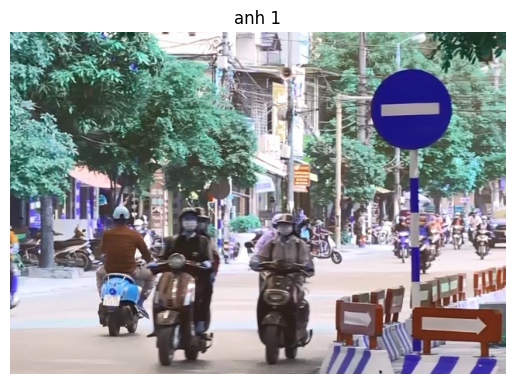

In [5]:
img1_path = r"/kaggle/input/test-anh/anh_test.jpg"
img1_rgb = cv2.imread(img1_path)

# plt.figure(figsize=(20, 15))
plt.imshow(img1_rgb, cmap='gray')
plt.title('anh 1')
plt.axis('off')
plt.show()

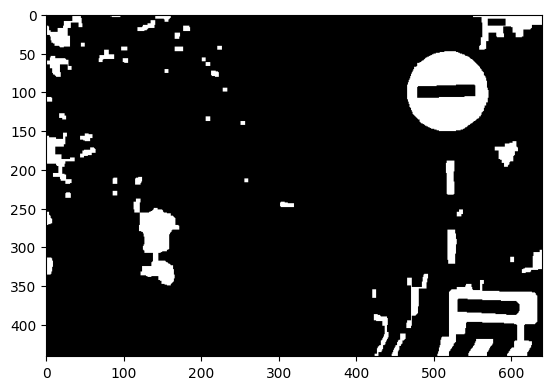

In [6]:
def convert_image_to_mask(img):
    img_float = img.astype(np.float32) / 255.0 + 1e-6
    (R, G, B) = cv2.split(img_float)
    r = R / (R + G + B + 1e-6)
    g = G / (R + G + B + 1e-6)
    b = B / (R + G + B + 1e-6)
        
    S = 1.0 - 3.0 * np.minimum(r, np.minimum(g, b))
    s_channel = S * 255
    s_channel = s_channel.astype(np.uint8)
    _, mask_S = cv2.threshold(s_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8)

    clean_mask = cv2.morphologyEx(mask_S, cv2.MORPH_OPEN, kernel, iterations=1)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return clean_mask

mask = convert_image_to_mask(img1_rgb)
plt.imshow(mask, cmap='gray')
plt.show()

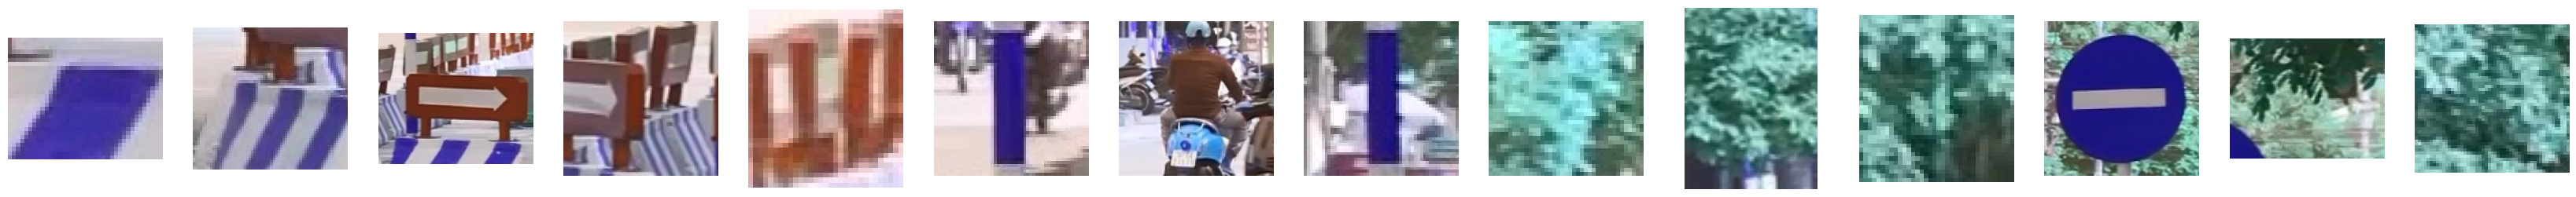

In [7]:
def ROI_mask(img_rgb, mask):

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    rois = []
    boxes = []
    
    # Lấy kích thước ảnh gốc để kiểm tra biên
    img_h, img_w = img_rgb.shape[:2]

    for cnt in contours:
        # --- LỌC 1: BỎ QUA NHIỄU NHỎ ---
        if cv2.contourArea(cnt) < 200:
            continue

        # 2. Lấy khung bao chữ nhật cơ bản
        x, y, w, h = cv2.boundingRect(cnt)

        # --- XỬ LÝ: BIẾN THÀNH HÌNH VUÔNG & THÊM ĐỆM (PADDING) ---
        # (Bước này cực quan trọng để ảnh không bị méo khi resize về 64x64)
        
        # Lấy cạnh lớn nhất làm chuẩn
        side = max(w, h)
        
        # Tính lượng đệm thêm vào (ví dụ 10%)
        pad = int(side * 0.1)
        new_side = side + 2 * pad
        
        # Tính tâm của vật thể cũ
        cx = x + w // 2
        cy = y + h // 2
        
        # Tính tọa độ góc trên-trái mới (để hình vuông căn giữa tâm)
        new_x = cx - new_side // 2
        new_y = cy - new_side // 2

        # --- KIỂM TRA BIÊN (CHỐNG LỖI TRÀN ẢNH) ---
        # Đảm bảo toạ độ không âm và không vượt quá kích thước ảnh
        x1 = max(0, new_x)
        y1 = max(0, new_y)
        x2 = min(img_w, new_x + new_side)
        y2 = min(img_h, new_y + new_side)

        # Kiểm tra lại lần cuối xem ảnh cắt ra có hợp lý không (tránh cắt ra ảnh 0x0)
        if (x2 - x1) < 10 or (y2 - y1) < 10:
            continue

        # 3. Cắt ảnh
        roi = img_rgb[y1:y2, x1:x2]
        
        rois.append(roi)
        boxes.append((x1, y1, x2 - x1, y2 - y1))

    return rois, boxes

ROI_list, roi_boxes = ROI_mask(img1_rgb, mask)

plt.figure(figsize=(3 * len(ROI_list), 3))
for i, roi_image in enumerate(ROI_list):
    plt.subplot(1, len(ROI_list), i + 1)
    plt.imshow(roi_image)
    plt.axis('off')
    
plt.show()

Using CUDA


100%|██████████| 69/69 [01:30<00:00,  1.31s/it]


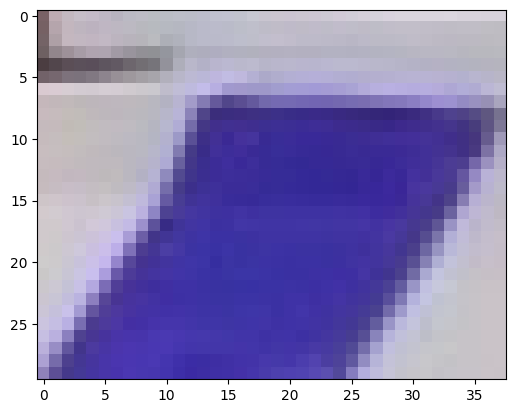

[43]


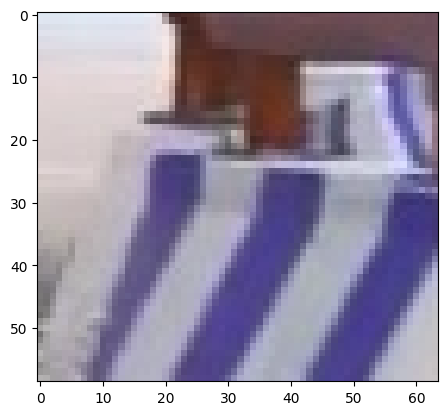

[43]


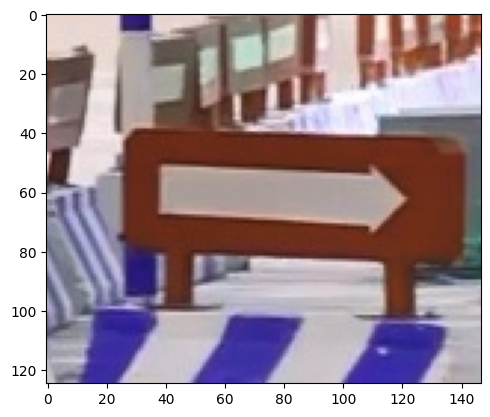

[43]


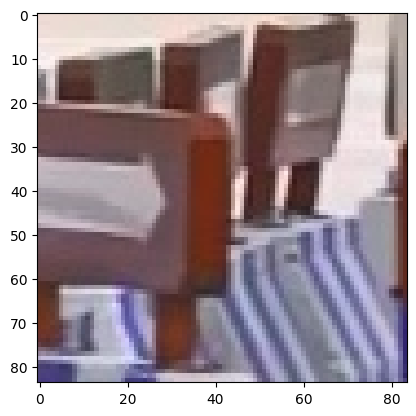

[43]


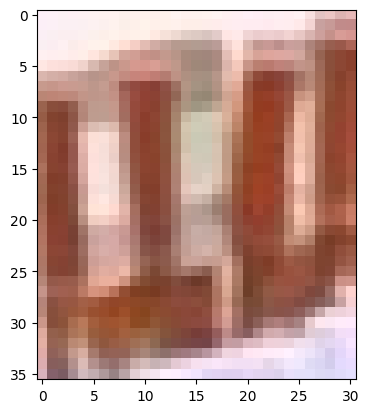

[43]


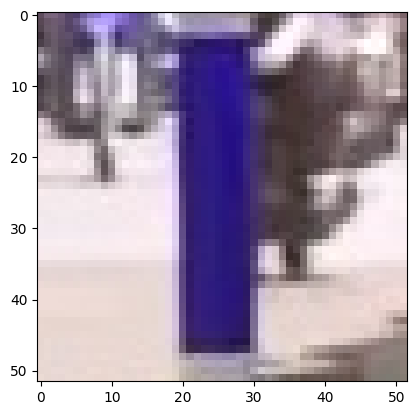

[43]


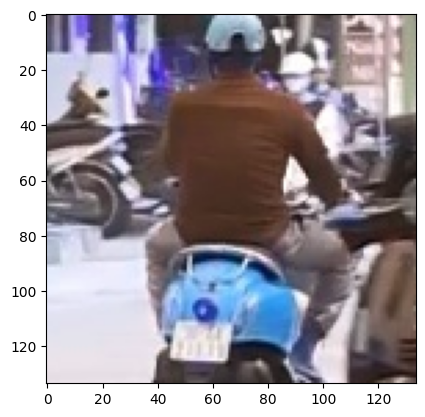

[43]


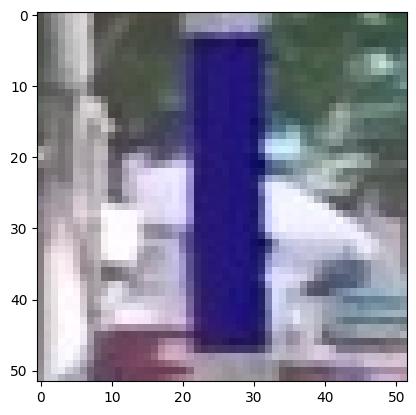

[43]


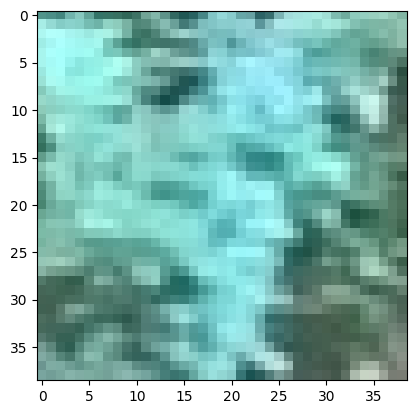

[43]


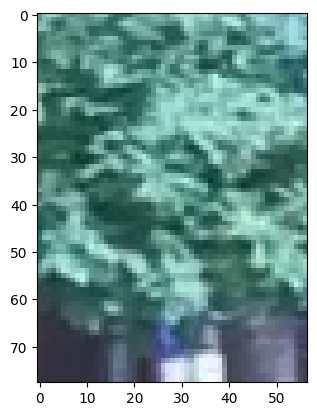

[43]


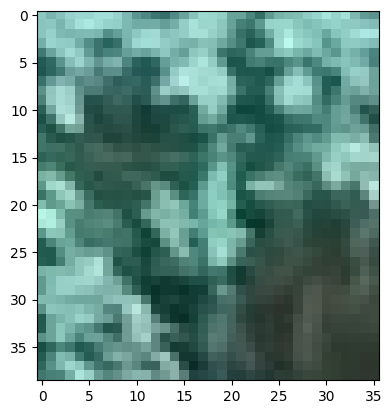

[43]


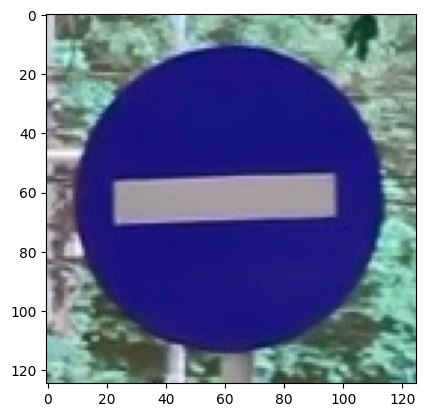

[17]


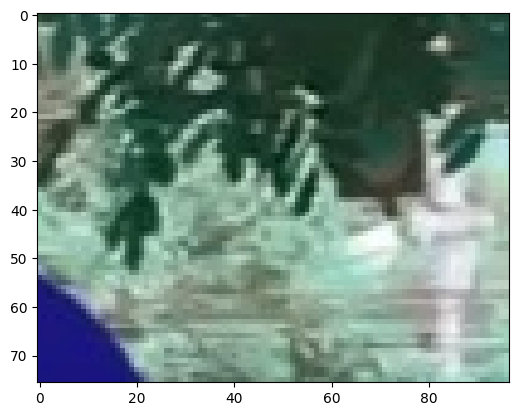

[43]


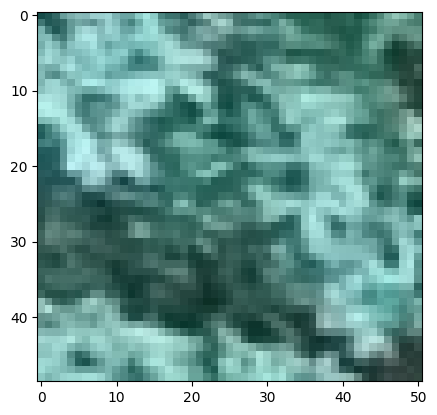

[43]


In [12]:
import numpy as np
import torch
from torchvision.transforms import ToPILImage, ToTensor, Compose, Normalize, Resize
import torch.nn as nn
from collections import OrderedDict
# from BASE.CV.Recognize_traffic_sign.SiameseNetwork_scratch import Siamese
from sklearn.neighbors import KNeighborsClassifier
# from BASE.CV.Recognize_traffic_sign.Data4Knn import DataForKnn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
if __name__ == '__main__':
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("Using CUDA")
    else:
        device = torch.device('cpu')
        print("Using CPU")

    transform = Compose([
        ToPILImage(),
        Resize((105, 105)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    data = DataForKnn(root='/kaggle/input/dataset-traffic/Data', transform=transform, databaseSet=True)
    dataloader = DataLoader(dataset=data, shuffle=True, batch_size=64, drop_last=False)
    CLASS_NAMES = data.CLASS_NAMES

    checkpoint_path = '/kaggle/input/traffic-model/pytorch/default/1/SiameseModel_Traffic_Best.pt'
    checkpoint = torch.load(checkpoint_path)

    model = Siamese()

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        # If the checkpoint has 'module.' prefix, remove it
        name = k.replace("module.", "") if k.startswith("module.") else k
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    model.to(device)
    model.eval()

    knn = KNeighborsClassifier(n_neighbors=5)
    actual_label = []
    vector_store = []
    with torch.inference_mode():
        progressbar = tqdm(dataloader)
        for iter, (image, label) in enumerate(progressbar):
            image = image.to(device)
            embed_vector = model.forward_once(image)
            vector_store.extend(embed_vector.cpu().numpy())
            actual_label.extend(label.numpy())

    knn.fit(X=np.array(vector_store), y=np.array(actual_label))

    model.eval()
    with torch.inference_mode():
        for image in ROI_list:
            plt.imshow(image)
            plt.show()
            image=transform(image)
            image=image.to(device).unsqueeze(0)
            embed_vector=model.forward_once(image)
            embed_vector=embed_vector.cpu().numpy()
            print(knn.predict(embed_vector))